# Bloqs

We aim to represent quantum programs in a form that is both expressive, follows the rules of QM, and is usable by humans.

As a motivating example, consider existing libraries like Cirq and Qiskit. `cirq.Circuit` and `QuantumCircuit` are data structures representing a quantum program. These aren't traditional programming languages, but rather "hosted languages" where Python data structures represent the program and Python functions can manipulate the program. Runtimes for these languages support a small number of qubits and include numerical simulators or waveform compilers for execution on hardware.

In [ ]:
from attrs import define, frozen
from typing import *

In [ ]:
@define
class Circuit0:
    """This is a simple way of using a python data structure to host a quantum
    programming language.
    
    It's a simple list of operations, which we define as a string name and 
    integer qubit addresses.
    """
    ops: List['Op_T']


Op_T = Tuple[str, Tuple[int, ...]]

In [ ]:
bell_circuit = Circuit0(ops=[
    ('H', (0,)),
    ('CNOT', (0, 1))
])

Depending on the runtime, this isn't as silly as it seems. To compile this to actual waveforms for execution on a prototype quantum computing device, there's likely a table of gate calibrations, so the string name is fine and addressing your qubits by integers is just fine. Likewise, a classical simulator could easily be written for this circuit representation.

These frameworks are low-level programming languages where explicit memory addresses (i.e. qubit identifiers) are managed by the developer. We want a high-level language, still hosted in Python with the following key features: 
 - fully recursive: each operation can be defined as a collection of (sub)operations. There's a unified interface for atomic operations with a decomposition and container gates (todo: rewrite)
 - Operations operate on quantum variables. Quantum variables can only be used within a circuit (todo: define) and must be used linearly: namely each quantum variable must be used once and only once.
 
What do you mean? I have a qubit and I can keep operating on it over and over. A qubit should not be confused with a quantum variable. `add(a, a)` is ok but `cnot(q, q)` is not. 

Operations can be unitary (each input quantum variable has a corresponding output quantum variable; the operation can be inverted where outputs become inputs --> conservation of quantum information). Operations can be "allocations" where we start with nothing but get a quantum variable. They can be "deallocations" where we discard a quantum variable. Operations can be a mixture of these two things: for example a quantum "AND" operation can be written as two input control qvars, an allocation of a fresh target qvar, a unitary toffli, and three output qvars. 



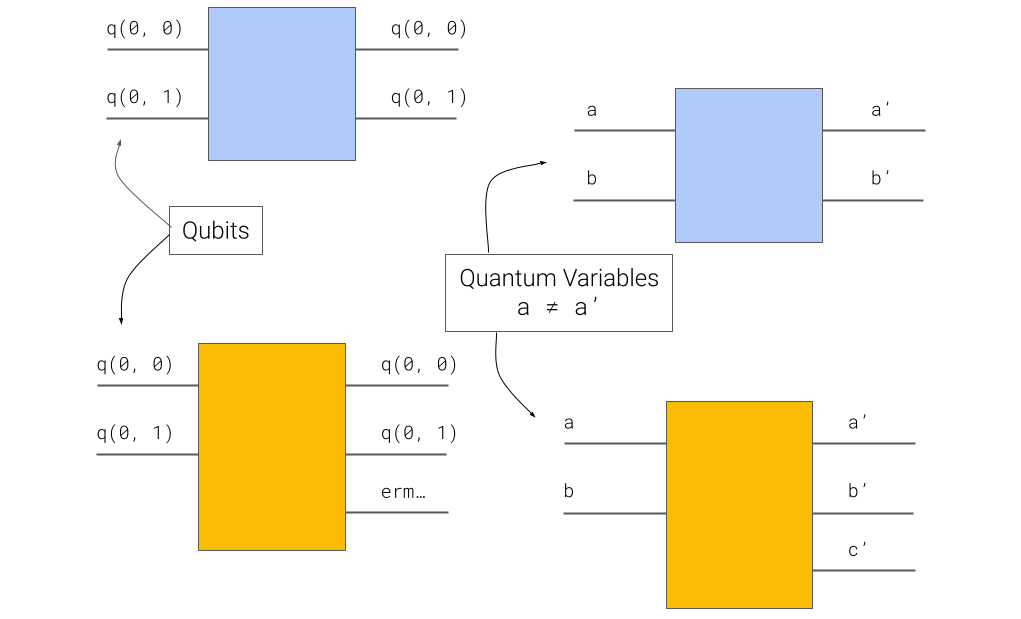

Like the photo, we'll redefine operations from a gate name and qubit addresses to a gate name and quantum variables. Here, we lift the restriction that each operation must have the same number of input and output qubits. 

In [ ]:
@frozen
class Operation1:
    gate: str
    invars: Tuple['QVar', ...]
    outvars: Tuple['QVar', ...]
        
@define
class Circuit1:
    ops: List[Operation1]

What are our quantum variables `QVar`? Right now, we just need them to be unique objects. We'll use the fact that each Python object has a unique `id()` which is used for equality and hashing (by default; contrast with `attrs` dataclasses that use value-equality by default).

In [ ]:
class QVar:
    def __repr__(self):
        return f'q{hex(id(self))[2:]}'
    
QVar(), QVar(), QVar()

In [ ]:
a, b = QVar(), QVar()
a2 = QVar()
a3, b3 = QVar(), QVar()

c = Circuit1([
    Operation1('H', invars=(a,), outvars=(a2,)),
    Operation1('CNOT', invars=(a2, b), outvars=(a3, b3)),
])
c

In [ ]:
from simple_quantum_graph import *

In [ ]:
CNOT

In [ ]:
@frozen
class QVar:
    """Simple container for quantum variables."""
    _id: str
        
import random
import string
        
def qvar(prefix: str) -> QVar:
    r = ''.join(random.choices(string.ascii_letters, k=4))
    return QVar(f'{prefix}-{r}')

In [ ]:
@frozen
class Op:
    name: str
    invars: Tuple[QVar, ...]
    outvars: Tuple[QVar, ...]

In [ ]:
a, b = qvar('a'), qvar('b')
a2, b2 = qvar('a'), qvar('b')

cnot1 = Op('cnot', (a,b), (a2,b2))

a3, b3 = qvar('a'), qvar('b')
cnot2 = Op('cnot', (a2,b2), (a3,b3))

program = [
    cnot1,
    cnot2,
]
program

In [ ]:
a, b = qvar('a'), qvar('b')
a2, b2 = qvar('a'), qvar('b')

cnot1 = Op('cnot', (a,b), (a2,b2))

a3, b3 = qvar('a'), qvar('b')
cnot2 = Op('cnot', (b2, a2), (b3, a3))

program2 = [
    cnot1,
    cnot2,
]
program2

In [ ]:
import networkx as nx
g = nx.DiGraph()
pos = {}

for i, op in enumerate(program2):
    for j, invar in enumerate(op.invars):
        g.add_node((i, 'in', j))
        pos[(i, 'in', j)] = (i, j)
        
        for i2, op2 in enumerate(program2):
            for j2, prev_out in enumerate(op2.outvars):
                if invar == prev_out:
                    g.add_edge((i2, 'out', j2), (i, 'in', j))
        
    for j, outvar in enumerate(op.outvars):
        g.add_node((i, 'out', j))
        pos[(i, 'out', j)] = (i+0.5, j)
        
    for j, (_, _) in enumerate(zip(op.invars, op.outvars)):
        g.add_edge((i, 'in', j), (i, 'out', j), kind='intraop')
        
nx.draw_networkx(g, pos=pos)        

In [ ]:
a, b = qvar('a'), qvar('b')
a2, b2 = qvar('a'), qvar('b')

cnot1 = Op('cnot', (a,b), (a2,b2))

a3, b3 = qvar('a'), qvar('b')
cnot2 = Op('cnot', (b2, a2), (b3, a3))

program2 = [
    cnot1,
    cnot2,
]
program2

In [ ]:
a = qvar('a')
b = qvar('b')
a, b

In [ ]:
class Op:
    ...

class CNOT(Op):
    def __call__(self, ctrl: QVar, trg: QVar):
        # ... do the cnot somehow
        return qvar('ctrl'), qvar('trg')
    
    def __repr__(self):
        return f'CNOT{id(self)}'

circuit = []
circuit.append(CNOT())
circuit.append(CNOT())
circuit

A simplified version of a hosted language in Python. Each type of operation gets a class. The program is a container of operation instances.

In the Cirq style: we have a class for each operation. Actually calling the operation assumes some sort of runtime. This can be a classical simulator or a compiler can generate analog waveforms to shoot at acual qubits. 

Our circuit consists of two CNOT operations. But we're clearly missing information: how do the quantum variables propogate through the program.

In [ ]:
@define
class Program:
    ops: List[Op] = Factory(list)
    inps: Dict[Op, Tuple[QVar, ...]] = Factory(dict)
        
    def __repr__(self):
        s = ''
        for op in self.ops:
            s += f'{op}\n'
            for qvar in self.inps[op]:
                s += f'  {qvar}\n'
        return s
    

In [ ]:
def add_cnot(prog, ctrl: QVar, trg: QVar):
    op = CNOT()
    prog.ops.append(op)
    prog.inps[op] = (ctrl, trg)
    return qvar('ctrl'), qvar('trg')

Program.add_cnot = add_cnot

In [ ]:
prog = Program()
a2, b2 = prog.add_cnot(a, b)
a3, b3 = prog.add_cnot(a2, b2)
prog

In [ ]:
prog = Program()
a2, b2 = prog.add_cnot(a, b)
a3, b3 = prog.add_cnot(b2, a2)
a4, b4 = prog.add_cnot(a3, b3)
prog

In [ ]:
def check_linear_type(prog: Program):
    seen = set()
    for inps in prog.inps.values():
        for qvar in inps:
            if qvar in seen:
                raise ValueError(f"{qvar} used more than once!")
            seen.add(qvar)
            
check_linear_type(prog)

In [ ]:
bad_prog = Program()
a2, b2 = bad_prog.add_cnot(a, a)
bad_prog

In [ ]:
check_linear_type(bad_prog)

In [ ]:
bad_prog = Program()
a2, b2 = bad_prog.add_cnot(a, b)
a3, b3 = bad_prog.add_cnot(a, b)
check_linear_type(bad_prog)

In [ ]:
@define
class Program2:
    ops: List[Op] = Factory(list)
    inps: Dict[Op, Tuple[QVar, ...]] = Factory(dict)
    outs: Dict[Op, Tuple[QVar, ...]] = Factory(dict)

        
    def __repr__(self):
        s = ''
        for op in self.ops:
            s += f'{op}\n'
            for qvar in self.inps[op]:
                s += f'  {qvar}\n'
            s += '  -----\n'
            for qvar in self.outs[op]:
                s += f'  {qvar}\n'
        return s

In [ ]:
class INIT0(Op):
    def __repr__(self):
        return f'INIT0{id(self)}'

def init0(prog):
    op = INIT0()
    prog.ops.append(op)
    q = qvar('0')
    
    prog.inps[op] = tuple()
    prog.outs[op] = (q, )
    return q

Program2.add_cnot = add_cnot
Program2.init0 = init0

In [ ]:
prog = Program2()
a = prog.init0()
b = prog.init0()
a2, b2 = prog.add_cnot(a, b)
prog

In [ ]:
circuit = []
inps = {}

def add_CNOT(ctrl:QVar, trg:QVar):
    op = CNOT()
    circuit.append(op)
    inps[op] = (ctrl, trg)
    return QVar('ctrl_prime'), QVar('trg_prime')

aprime, bprime = add_CNOT(a, b)
add_CNOT(aprime, bprime)


for op in circuit:
    print(op)
    for qvar in inps[op]:
        print(' ', qvar)


In [ ]:
import numpy as np
_I = np.array([
    [1,0],
    [0,1],
])
_X = np.array([
    [0,1],
    [1,0],
])
_NULL = np.zeros((2,2))
_CNOT = np.array([
    [_I, _NULL],
    [_NULL, _X],
])
_CNOT.reshape(4,4)

In [ ]:
circuit = []
circuit.append(CNOT())
circuit

In [ ]:
CNOT(a, b)

In [ ]:
CNOT(a, a)